In [184]:
from scipy.io import arff
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap

## Part - A

### Loading data

In [204]:
# Replace 'your_file.arff' with the actual path to your ARFF file
train_data = arff.loadarff('./yeast/yeast-train.arff')
test_data = arff.loadarff("./yeast/yeast-test.arff")

# test dataframe
train_df = pd.DataFrame(train_data[0])
test_df = pd.DataFrame(test_data[0])

# changing the y_label data
for col in train_df.columns[-14:]:
    train_df[col] = train_df[col].apply(lambda x: int(x))
    test_df[col] = test_df[col].apply(lambda x: int(x))

# To see for which class it belongs to (for each datapoint)
train_df['label'] = train_df.iloc[:,-14:].apply(lambda row: tuple(col for col in train_df.iloc[:,-14:].columns if row[col] == 1), axis=1)
test_df['label'] = test_df.iloc[:,-14:].apply(lambda row: tuple(col for col in test_df.iloc[:,-14:].columns if row[col] == 1), axis=1)

In [205]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 118 entries, Att1 to label
dtypes: float64(103), int64(14), object(1)
memory usage: 1.4+ MB


In [206]:
train_df.head(3)

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14,label
0,0.093700,0.139771,0.062774,0.007698,0.083873,-0.119156,0.073305,0.005510,0.027523,0.043477,...,0,0,0,0,0,0,0,0,0,"(Class3, Class4)"
1,-0.022711,-0.050504,-0.035691,-0.065434,-0.084316,-0.378560,0.038212,0.085770,0.182613,-0.055544,...,0,1,1,0,0,0,1,1,0,"(Class7, Class8, Class12, Class13)"
2,-0.090407,0.021198,0.208712,0.102752,0.119315,0.041729,-0.021728,0.019603,-0.063853,-0.053756,...,0,0,0,0,0,0,1,1,0,"(Class2, Class3, Class12, Class13)"


In [207]:
print(f"14 classes are there for the Y")
print(f"Initial no of feat : {train_df.shape[1]-14}")
print(f"Initial no of datapoints : {train_df.shape[0]}")

14 classes are there for the Y
Initial no of feat : 104
Initial no of datapoints : 1500


In [208]:
(tuple(map(lambda x: len(x) == 1, train_df['label'])))
train_df['label'] == 1

0       False
1       False
2       False
3       False
4       False
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: label, Length: 1500, dtype: bool

In [209]:
train_df[train_df["label"].map(len) <= 1].iloc[:,-15:-1].sum(axis = 0).sort_values(ascending=False)

Class1     24
Class2      0
Class3      0
Class4      0
Class5      0
Class6      0
Class7      0
Class8      0
Class9      0
Class10     0
Class11     0
Class12     0
Class13     0
Class14     0
dtype: int64

In [210]:
class_freq = train_df[train_df["label"].map(len) == 1]['label'].value_counts().sort_values(ascending=False)
display(class_freq)

print(f"The top frequnent classes are : \n{class_freq[:2]}")
print(F"Only one class is there for which the data point is single class, in place of top 2 frequent classes, we have only (Class1,)")
top_single = class_freq.head(2).index.tolist()

label
(Class1,)    24
Name: count, dtype: int64

The top frequnent classes are : 
label
(Class1,)    24
Name: count, dtype: int64
Only one class is there for which the data point is single class, in place of top 2 frequent classes, we have only (Class1,)


In [211]:
## Creating a label for the top occuring combination
multi_class_freq = train_df['label'].value_counts().sort_values(ascending=False)

print(f"Top 5 multiclass combo")
display(multi_class_freq[:5])

# Step 4: Find most frequent multi-label combination
top_multi = multi_class_freq.head(1).index.tolist()

Top 5 multiclass combo


label
(Class4, Class5, Class12, Class13)    145
(Class3, Class4, Class12, Class13)    145
(Class1, Class2, Class12, Class13)    105
(Class1, Class2)                       80
(Class2, Class3, Class12, Class13)     77
Name: count, dtype: int64

In [212]:
# Step 5: Create visualization target column
def assign_group(labels):
    if labels in top_single:
        return labels[0]   # unwrap tuple ('CYT',) → 'CYT'
    elif labels in top_multi:
        return "+".join(labels)
    else:
        return "Other"

train_df["viz_target"] = train_df["label"].apply(assign_group)
train_df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14,label,viz_target
0,0.093700,0.139771,0.062774,0.007698,0.083873,-0.119156,0.073305,0.005510,0.027523,0.043477,...,0,0,0,0,0,0,0,0,"(Class3, Class4)",Other
1,-0.022711,-0.050504,-0.035691,-0.065434,-0.084316,-0.378560,0.038212,0.085770,0.182613,-0.055544,...,1,1,0,0,0,1,1,0,"(Class7, Class8, Class12, Class13)",Other
2,-0.090407,0.021198,0.208712,0.102752,0.119315,0.041729,-0.021728,0.019603,-0.063853,-0.053756,...,0,0,0,0,0,1,1,0,"(Class2, Class3, Class12, Class13)",Other
3,-0.085235,0.009540,-0.013228,0.094063,-0.013592,-0.030719,-0.116062,-0.131674,-0.165448,-0.123053,...,0,0,0,0,0,1,1,1,"(Class3, Class4, Class12, Class13, Class14)",Other
4,-0.088765,-0.026743,0.002075,-0.043819,-0.005465,0.004306,-0.055865,-0.071484,-0.159025,-0.111348,...,0,0,0,0,0,0,0,0,"(Class1, Class2)",Other


**Why scaling is important**

- All distance based methods like PCA, t-SNE, k-means etc... reply on euclidean distance

- If the scales of the variables are different, then it will inherently create bias by increasing the variance fr the particular variable

- This will create a bias in the algorithm, by giving high importance to those highly scaled variable. Even it is only as important as others

- caling ensures all features contribute equally to distance calculations.

- Standardization is the most common choice:

    - 𝑥′ = (𝑥 − 𝜇)/𝜎

    - This makes the mean zero and the variance = 1, for all the variables, now we can use it in our algorithms without scaling issues


In [213]:
# standardizing the data
X_train, Y_train = train_df.iloc[:,:-16], train_df['viz_target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Task B

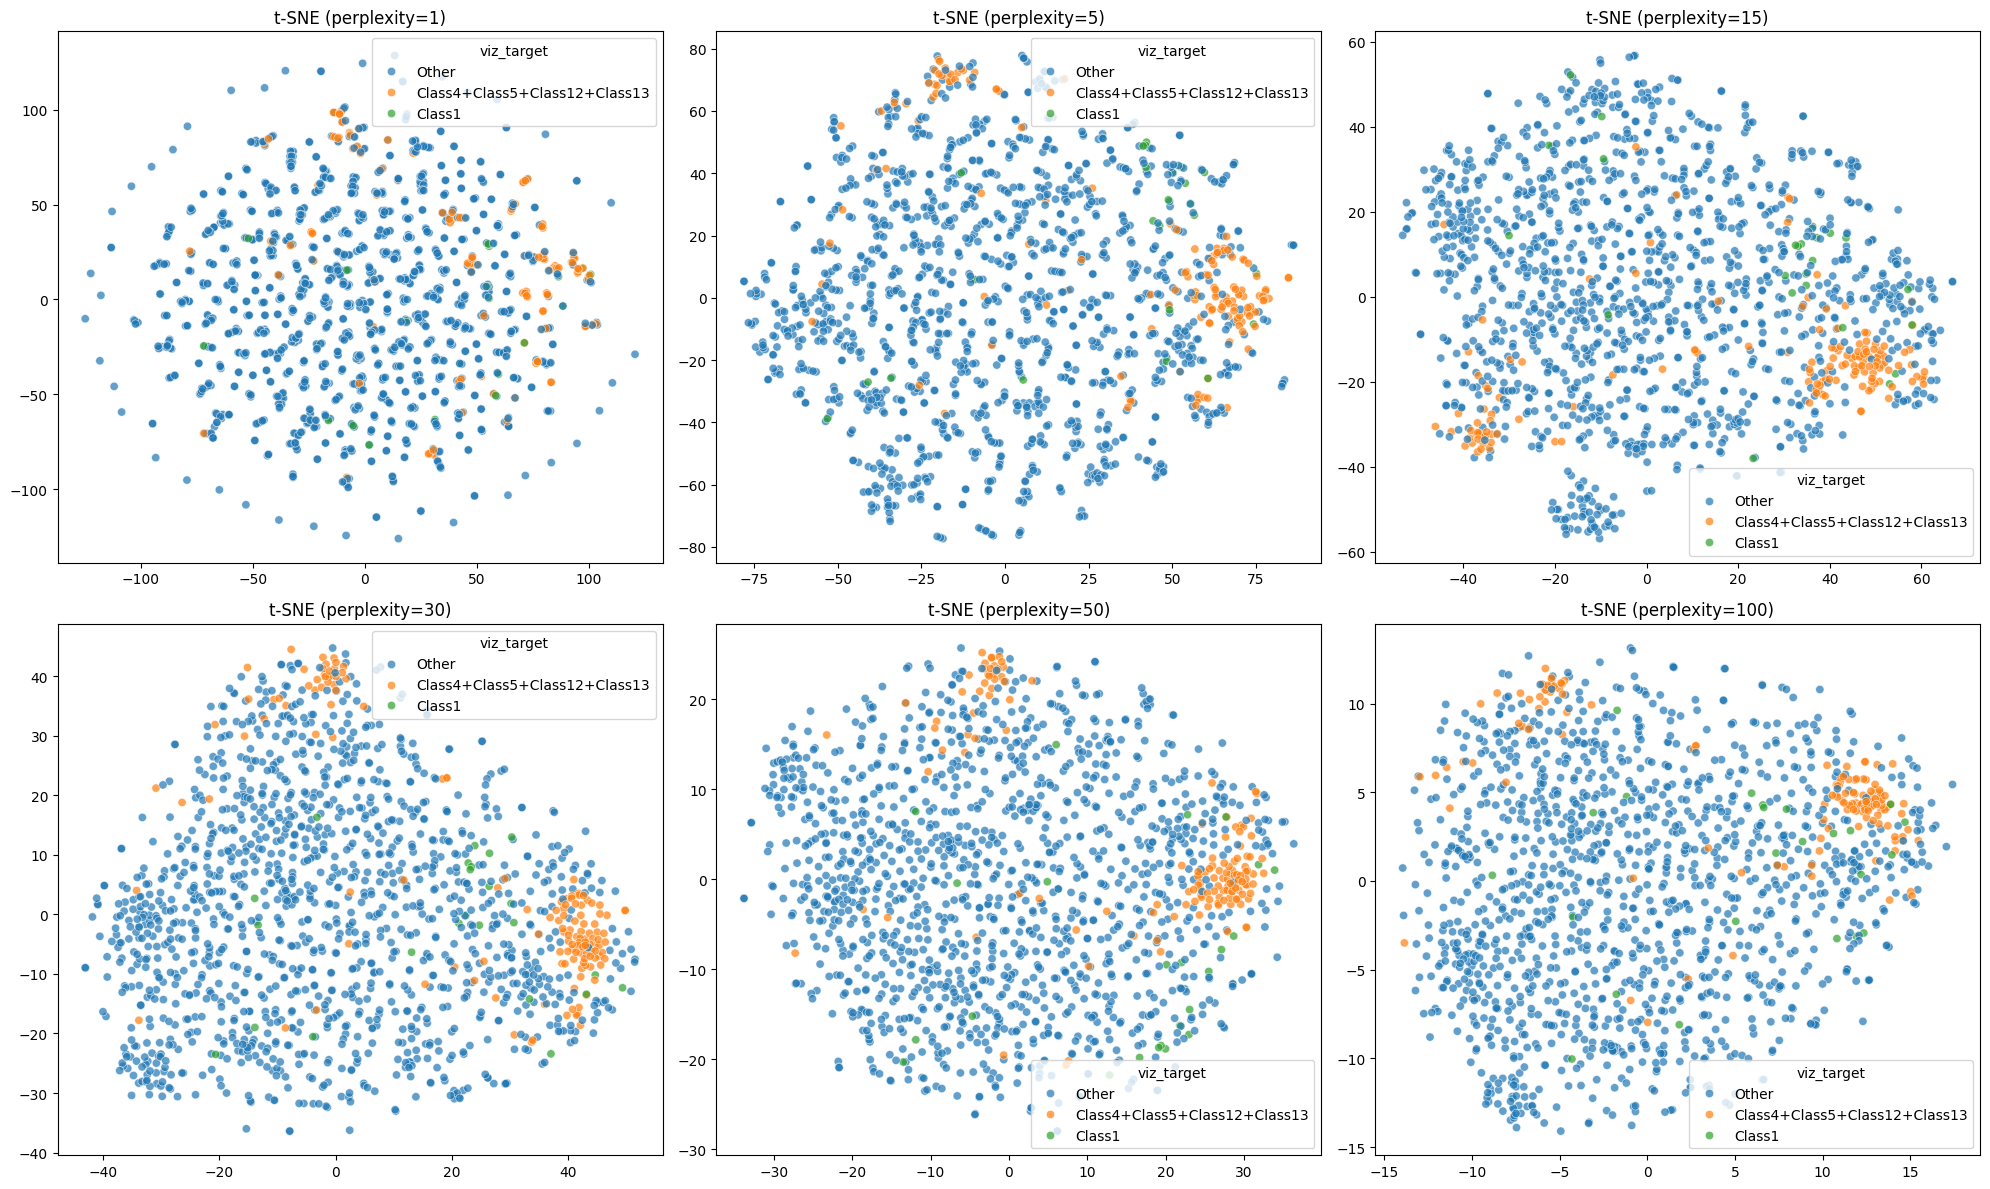

In [214]:
perplexities = [1, 5, 15, 30, 50, 100]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    X_embedded = tsne.fit_transform(X_train_scaled)
    
    sns.scatterplot(
        x=X_embedded[:,0], y=X_embedded[:,1],
        hue=Y_train,
        palette="tab10",
        alpha=0.7,
        ax=axes[i]
    )
    axes[i].set_title(f"t-SNE (perplexity={perp})")

plt.tight_layout()
plt.show()

***Best Perplexity = 30***

- Very clear separation: classes form smoother, rounder clusters with noticeable gaps.

- Good trade-off between local neighborhood preservation and global organization

- (a) **Noisy / Ambiguous Labels** 

    - Points where an orange or green dot is deep inside a blue cluster, or vice versa.

    - These could be due to:

        - Mislabeling in the dataset.

        - Also could be a true overlap in gene/protein/expression profiles.

- (b) **Outliers** 

    - Isolated points far from any cluster, or tiny detached groups.

    - Likely causes:

        - Rare biological conditions.

        - Experimental artifacts (bad sequencing runs, measurement noise).

        - Samples with unique combinations not seen elsewhere.

- (c) ***Hard-to-Learn Samples***

    - Dense mixed regions, where blue, orange, and green dots are intermixed.

    - Why problematic?

        - A classifier (like logistic regression or decision trees) struggles since boundaries are nonlinear and fuzzy.

        - These samples don’t have a dominant local neighborhood label, so they’ll often be misclassified.

### Isomap

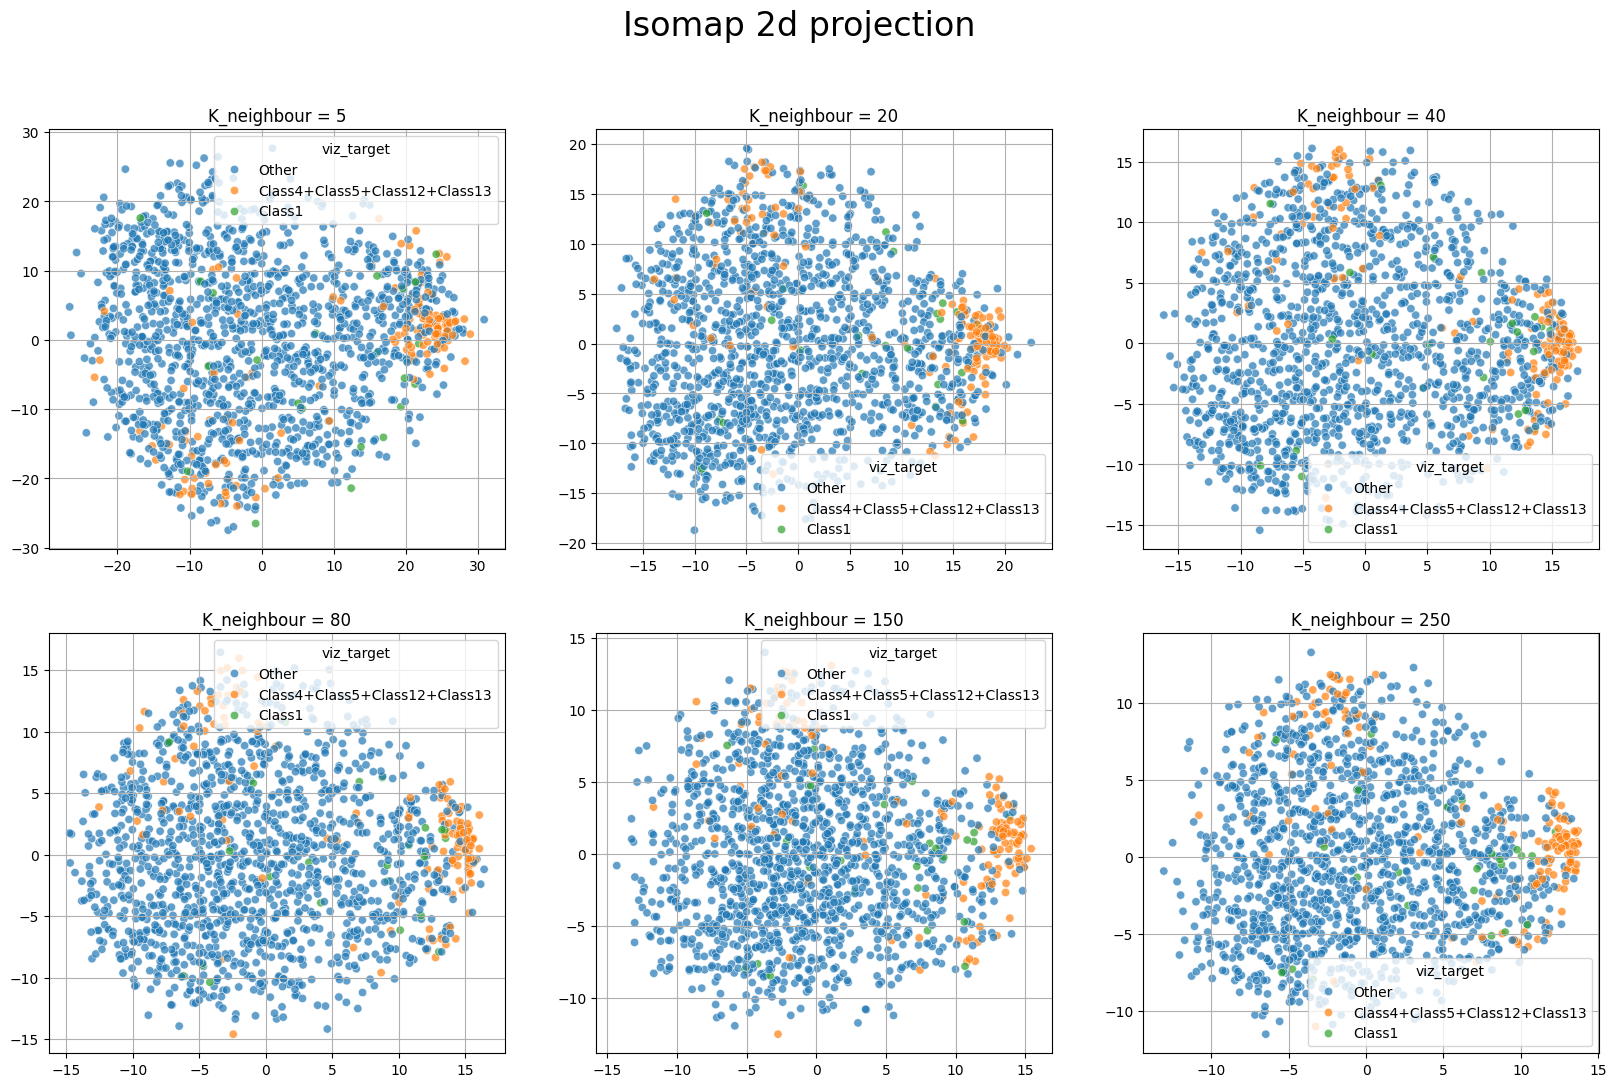

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [218]:
# Initialize Isomap

k_neighbours = [5, 20, 40, 80, 150, 250]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()
plt.suptitle("Isomap 2d projection", size = 24)

for i, k_n in enumerate(k_neighbours):
    
    isomap = Isomap(n_components=2, n_neighbors=k_n)  
    X_iso = isomap.fit_transform(X_train_scaled)

    # Visualization
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=X_iso[:,0], y=X_iso[:,1],
        hue=Y_train,
        palette="tab10",
        alpha=0.7,
        ax=axes[i]
    )

    axes[i].set_title(f"K_neighbour = {k_n}")
    axes[i].grid()

plt.tight_layout()

***Best k_neighbours = 20***

- Good separation: Better clusters with good seperation between different clusters without merging of different clusters.

- Parts Doesn't get disconnected and also it is able to preserve the global structure well with good trade-off

***Isomap vs t-SNE***

| Aspect                           | Isomap                                                                                                                                                                                           | t-SNE                                                                                                                                                               |
| -------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Goal**                         | Preserve **global geometry** of the manifold.                                                                                                                                                    | Preserve **local neighborhoods** (high-dimensional similarity).                                                                                                     |
| **How it works**                 | 1. Construct a **k-nearest neighbor graph**.<br>2. Compute **geodesic distances** (shortest paths along the graph).<br>3. Apply **classical MDS** to embed points preserving geodesic distances. | 1. Compute **pairwise similarities** as probabilities.<br>2. Find low-dimensional embedding minimizing **KL divergence** between high-dim and low-dim similarities. |
| **Preserves**                    | **Global structure** (distances along the manifold, overall shape).                                                                                                                              | **Local structure** (neighbors stay close), global distances may distort.                                                                                           |
| **Visualization effect**         | Shows **overall manifold shape**, less clustering.                                                                                                                                               | Emphasizes **tight clusters**, can exaggerate separations.                                                                                                          |
| **Parameters affecting results** | `n_neighbors` (defines local graph)                                                                                                                                                              | `perplexity` (defines effective neighborhood)                                                                                                                       |


**t-SNE (best at perplexity ≈ 30):**

- Produces compact, well-separated local clusters.

- Points of the same class are grouped together tightly.

- However, the relative distances between clusters are not meaningful — two clusters close in the 2D plot may not be close in the original space.

- In your yeast dataset, t-SNE clearly shows pockets of “Other” vs. “Class1” vs. “Multi-labels,” but cluster spacing is arbitrary.

***Isomap (best at k ≈ 20):***

- Produces a smoother global embedding where the data is spread in a more continuous structure.

- Captures the overall manifold shape, unfolding the data into a roundish, curved form.

- Unlike t-SNE, the relative positions in Isomap carry meaning: if two groups are closer, their geodesic distance in the original space was also smaller.

- However, local clusters are less distinct, and classes overlap more.

**Which is better at revealing global structure?**

- Isomap is better at revealing global layout (continuous spread, manifold unfolding).

- t-SNE is better at revealing local neighborhoods (tight same-class groupings).
So:

- If we want cluster discovery → t-SNE.

- If we want global gene-expression relationships → Isomap.

- A **data manifold** is the *lower-dimensional "surface" in high-dimensional space where the data lies*.

- If the manifold is flat, linear methods (like PCA, MDS) work well.

- If it is curved/non-linear, we need methods like Isomap, t-SNE.

- From Isomap plots:

- The embeddings don’t flatten into clear, simple clusters → instead, they form curved, elongated, overlapping shapes.

- This suggests the gene-expression data lies on a highly curved or twisted manifold.

***Implication for classification:***

- A highly curved manifold = complex decision boundaries.

- Linear classifiers (like logistic regression, linear SVM) will struggle.

- Non-linear models (kernel SVM, tree ensembles, deep nets) will handle it better.

- The mixed regions in both t-SNE and Isomap confirm that some samples are hard-to-separate without flexible models.